In [1]:
# Import relevant modules
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
import pybird
from importlib import reload
from copy import deepcopy
from scipy.interpolate import interp1d
import scipy.optimize as op
from scipy import stats
def pvalue(minchi2, dof):
    return 1. - stats.chi2.cdf(minchi2, dof)
from scipy.interpolate import UnivariateSpline

In [2]:
font = {'size': 12, 'family': 'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

In [3]:
zpk = .57
kdata = np.arange(0.01, 0.31, 0.005)
sdata = np.arange(5, 200, 1)

In [4]:
from classy import Class
M = Class()
M.set({'omega_b': 0.02237, 'omega_cdm': 0.120, 'h': 0.6736, 'ln10^{10}A_s': 3.044, 'n_s': 0.9649})
M.set({'output': 'mPk', 'P_k_max_1/Mpc': 1.0, 'z_max_pk': zpk})
M.compute()
f1 = M.scale_independent_growth_factor_f(zpk) # growth rate
kk = np.logspace(-5, 0, 200) # k in h/Mpc
pklin = np.array([M.pk(k*M.h(), zpk)*M.h()**3 for k in kk]) # P(k) in (Mpc/h)**3
ipklin = interp1d(kk, pklin, kind='cubic')
pk11 = ipklin(kdata)
print (f1)

0.7818908365841581


In [5]:
def extrap(self, xin, f, extrap='extrap', window=1, Nmax=512):
    interpfunc = interp1d(xin, f, kind='cubic')
    fx = np.empty(Nmax)
    tmp = np.empty(int(Nmax / 2 + 1), dtype=complex)
    Coef = np.empty(Nmax + 1, dtype=complex)
    
    if extrap is 'extrap':
        if xin[0] > self.x[0]:
            #print ('low extrapolation')
            nslow = (log(f[1]) - log(f[0])) / (log(xin[1]) - log(xin[0]))
            Aslow = f[0] / xin[0]**nslow
        if xin[-1] < self.x[-1]:
            #print ('high extrapolation')
            nshigh = (log(f[-1]) - log(f[-2])) / (log(xin[-1]) - log(xin[-2]))
            Ashigh = f[-1] / xin[-1]**nshigh

        for i in range(self.Nmax):
            if xin[0] > self.x[i]:
                fx[i] = Aslow * self.x[i]**nslow
            elif xin[-1] < self.x[i]:
                fx[i] = Ashigh * self.x[i]**nshigh
            else:
                fx[i] = interpfunc(self.x[i])

In [6]:
kplot = np.logspace(-20, 20, 2000) 
# kplot = np.logspace(-5, 0, 200) 

In [7]:
from fftlog import FFTLog
fftsettings = dict(Nmax=256, xmin=1.5e-5, xmax=1000., bias=-1.6)
fft = FFTLog(**fftsettings)
pfftm1p6 = fft.sumCoefxPow(kk, pklin, kplot, window=0.)

In [8]:
fftsettings = dict(Nmax=256, xmin=1.5e-5, xmax=1000., bias=-.3)
fft = FFTLog(**fftsettings)
pfftm0p3 = fft.sumCoefxPow(kk, pklin, kplot, window=0.)

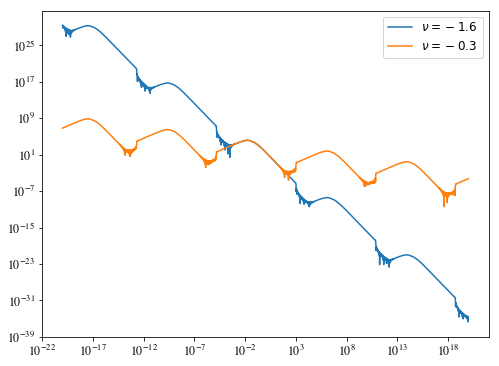

In [9]:
#plt.plot(kk, pklin)
plt.plot(kplot, np.abs(pfftm1p6*kplot**0), label=r'$\nu=-1.6$')
plt.plot(kplot, np.abs(pfftm0p3*kplot**0), label=r'$\nu=-0.3$')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [10]:
# np.savetxt("/Users/pierre/Desktop/fftlog_pk.dat", np.vstack([kplot, pfftm1p6, pfftm0p3]).T, header="k,nu=-1.6,nu=-0.3")


(1e-22, 1e+22)

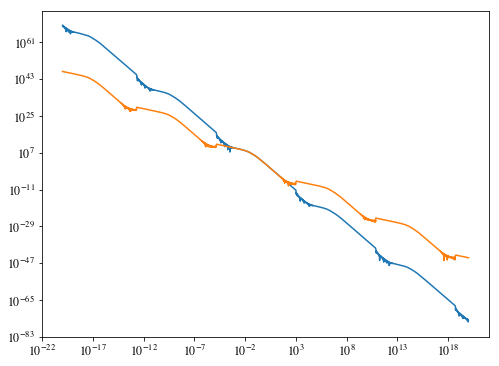

In [11]:
#plt.plot(kk, pklin/kk**2)
plt.plot(kplot, np.abs(pfftm1p6/kplot**2))
plt.plot(kplot, np.abs(pfftm0p3/kplot**2))
plt.xscale('log')
plt.yscale('log')
plt.xlim()

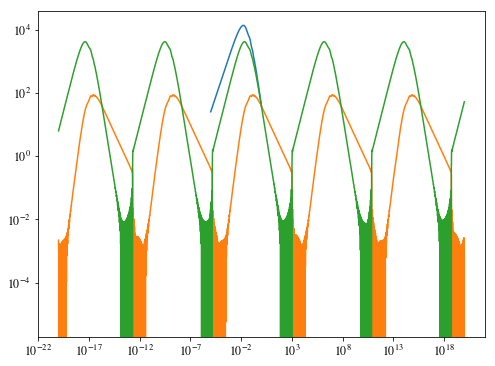

In [12]:
plt.plot(kk, pklin)
plt.plot(kplot, pfftm1p6/kplot**-1.6)
plt.plot(kplot, pfftm0p3/kplot**-0.3)
plt.xscale('log')
plt.yscale('log')

### Finite UV piece

In [13]:
mu = {
    0: {0: 1., 2: 0., 4: 0.},
    2: {0: 1. / 3., 2: 2. / 3., 4: 0.},
    4: {0: 1. / 5., 2: 4. / 7., 4: 8. / 35.},
    6: {0: 1. / 7., 2: 10. / 21., 4: 24. / 77.},
    8: {0: 1. / 9., 2: 40. / 99., 4: 48. / 148.}
}

In [14]:
sigma_v = np.trapz(pklin, x=kk)
print (sigma_v)

def uv_finite_cct(b1, b3, f1): 
    return (3*b1 - 64*b3)/1260. * sigma_v/np.pi**2
def uv_finite_cr1(b1, b3, f1): 
    return -(f1*(63 + 48*f1 + b1*(-2 + 35*f1)))/420. * sigma_v/np.pi**2
def uv_finite_cr2(b1, b3, f1):  
    return -(f1**2*(46 + 35*f1))/420. * sigma_v/np.pi**2
def uv_finite_p13(b1, b3, f1):
    b5, b6, b7 = uv_finite_cct(b1, b3, f1), uv_finite_cr1(b1, b3, f1), uv_finite_cr2(b1, b3, f1)
    return np.array([(2. * b1 * (b5 * mu[0][l] + b6 * mu[2][l] + b7 * mu[4][l]) + 2. * f1 * (b5 * mu[2][l] + b6 * mu[4][l] + b7 * mu[6][l])) * kdata**2 * pk11  for l in [0, 2, 4]])
def uv_finite_dm_easy():
    return uv_finite_cct(1, 1, 0)
# print (uv_finite_dm_easy()*0.7**2)

1117.3484384669769


In [15]:
# \Delta cct: ((3*b1 - 64*b3p)*IntdqP11*kM**2)/(1260.*Pi**2)
# \Delta cr1: -(f1*(63 + 48*f1 + b1*(-2 + 35*f1))*IntdqP11*kr**2)/(420.*Pi**2)
# \Delta cr2: -(f1**2*(46 + 35*f1)*IntdqP11*kr**2)/(420.*Pi**2)

In [16]:
cct = 0.7**2 * uv_finite_cct(1.901, -0.9743, f1)
cr1 = 0.7**2 * uv_finite_cr1(1.901, -0.9743, f1)
print (cct, cr1)

2.996366097765773 -15.361874729208933


### dark matter

In [17]:
pieces = ["full", "sptloop", "sptloop22", "sptloop13"]

In [18]:
reload(pybird)
ct = {'cct': 0.}
N = pybird.Correlator()
N.set({'output': 'mPk', 'multipole': 0, 'xdata': kdata, 'resum': False, 
       'keep_loop_pieces_independent': True, 'fftbias': -1.6})
N.compute({'k11': kk, 'P11': pklin})
pkm1p6 = []
for what in pieces: pkm1p6.append( N.get(ct, what=what) )

N = pybird.Correlator()
N.set({'output': 'mPk', 'multipole': 0, 'xdata': kdata, 'resum': False, 
       'keep_loop_pieces_independent': True, 'fftbias': -0.3})
N.compute({'k11': kk, 'P11': pklin})
pkm0p3 = []
for what in pieces: pkm0p3.append( N.get(ct, what=what) )

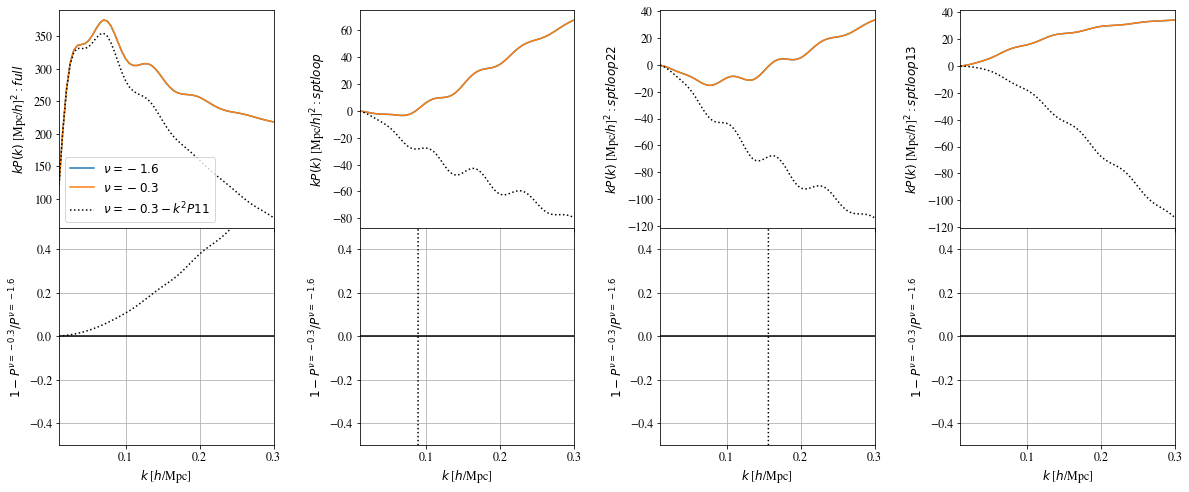

In [19]:
f, ax = plt.subplots(2, 4, figsize=(20,8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=.4, hspace=0)

uv_finite_dm =  uv_finite_p13(1, 1, 0)[0] 

for i, what in enumerate(pieces):
    ax[0,i].plot(kdata, kdata*pkm1p6[i][0], label=r'$\nu=-1.6$')
    ax[0,i].plot(kdata, kdata*pkm0p3[i][0], label=r'$\nu=-0.3$')
    ax[0,i].plot(kdata, kdata*(pkm0p3[i][0] + uv_finite_dm), 'k:', label=r'$\nu=-0.3 - k^2 P11$')
    ax[0,i].set_xlim(0.01, 0.3)
    ax[0,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[0,i].set_ylabel(r'$k P(k)$ [Mpc/$h$]$^{2} : %s$' % what)

    ax[1,i].plot(kdata, 1-pkm0p3[i][0]/pkm1p6[i][0], 'k')
    ax[1,i].plot(kdata, 1-(pkm0p3[i][0] + uv_finite_dm)/pkm1p6[i][0], 'k:')
    ax[1,i].set_xlim(0.01, 0.3)
    ax[1,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[1,i].set_ylabel(r'$1-P^{\nu=-0.3}/P^{\nu=-1.6}$')
    ax[1,i].set_ylim(-0.5, 0.5)
    ax[1,i].grid()

ax[0,0].legend()

### dark matter in redshift space

numerical

In [20]:
path = os.path.join("/", "Users", "pierre", "Documents", "github", "montepython_public-3.3", "bisp", "tmp", "0215") 
knum, mononump13 = np.loadtxt(os.path.join(path, "P13MonoDM.dat"), unpack=True)
knum, quadnump13 = np.loadtxt(os.path.join(path, "P13QuadDM.dat"), unpack=True)
knum, mononump22 = np.loadtxt(os.path.join(path, "P22MonoDM.dat"), unpack=True)
knum, quadnump22 = np.loadtxt(os.path.join(path, "P22QuadDM.dat"), unpack=True)

In [21]:
reload(pybird)
ct = {'cct': 1.2, 'cr1': -1.6}
N = pybird.Correlator()
N.set({'output': 'mPk', 'multipole': 2, 'xdata': kdata, 'resum': False, 'fftbias': -1.6,
       'keep_loop_pieces_independent': True, 'fftbias': -1.6})
N.compute({'k11': kk, 'P11': pklin, 'f': f1})
pkm1p6 = []
for what in pieces: pkm1p6.append( N.get(ct, what=what) )

N = pybird.Correlator()
N.set({'output': 'mPk', 'multipole': 2, 'xdata': kdata, 'resum': False, 'fftbias': -0.3,
       'keep_loop_pieces_independent': True, 'fftbias': -0.3})
N.compute({'k11': kk, 'P11': pklin, 'f': f1})
pkm0p3 = []
for what in pieces: pkm0p3.append( N.get(ct, what=what) )

Exception: cr2 not found, please provide (given command 'eft_basis': 'eftoflss') ['cct', 'cr1', 'cr2']

In [ ]:
sigma_v = np.trapz(pklin, x=kk)

def uv_finite_p13_pierre(b1, b3, f1):
    return 4*np.pi / (2*np.pi)**3 * np.array([  (b1**2/105. - (64*b1*b3)/315.)*mu[0][l]
                     + ((-186*b1*f1 + 6*b1**2*f1 - 64*b3*f1 - 144*b1*f1**2 - 105*b1**2*f1**2)*mu[2][l])/315. 
                     + ((-63*f1**2 - 44*b1*f1**2 - 48*f1**3 - 70*b1*f1**3)*mu[4][l])/105. 
                     + ((-46*f1**3)/105. - f1**4/3.)*mu[6][l] for l in [0,2,4] ])

In [ ]:
uv_finite_p13_pierre(1, 1, f1)[0]*sigma_v

In [ ]:
uv_finite_p13_pierre(1, 1, f1)[1]*sigma_v

In [ ]:
print ( (uv_finite_p13(1, 1, f1)[0] / (kdata**2*pk11*sigma_v) )[0] / uv_finite_p13_pierre(1, 1, f1)[0] )
print ( (uv_finite_p13(1, 1, f1)[1] / (kdata**2*pk11*sigma_v) )[0] / uv_finite_p13_pierre(1, 1, f1)[1] )

monopole

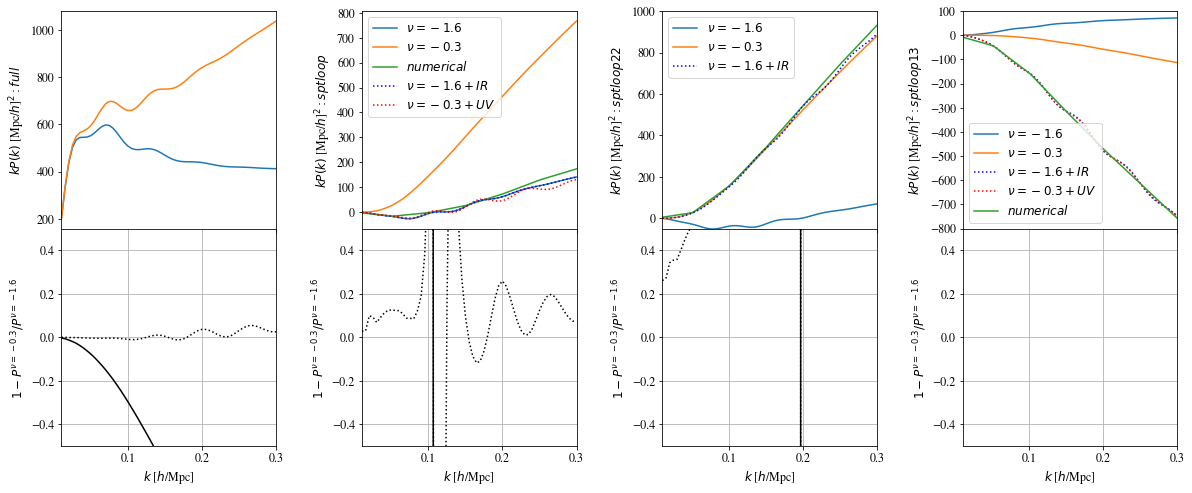

In [1099]:
f, ax = plt.subplots(2, 4, figsize=(20,8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=.4, hspace=0)

uv_finite_dm_13_mono =  uv_finite_p13_pierre(1, 1, f1)[0] * sigma_v * kdata**2 * pk11
ir_finite_dm_13_mono = -61.0738 * kdata**2 * pk11 

ir_finite_dm_22_mono = 2 * 30.5369 * kdata**2 * pk11 #+ 0.1 * pk11

for i, what in enumerate(pieces):
    ax[0,i].plot(kdata, kdata*pkm1p6[i][0], label=r'$\nu=-1.6$')
    ax[0,i].plot(kdata, kdata*pkm0p3[i][0], label=r'$\nu=-0.3$')
    ax[0,i].set_xlim(0.01, 0.3)
    ax[0,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[0,i].set_ylabel(r'$k P(k)$ [Mpc/$h$]$^{2} : %s$' % what)
    
    ax[1,i].plot(kdata, 1-pkm0p3[i][0]/pkm1p6[i][0], 'k')
    ax[1,i].plot(kdata, 1-(pkm0p3[i][0] + uv_finite_dm)/pkm1p6[i][0], 'k:')
    ax[1,i].set_xlim(0.01, 0.3)
    ax[1,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[1,i].set_ylabel(r'$1-P^{\nu=-0.3}/P^{\nu=-1.6}$')
    ax[1,i].set_ylim(-0.5, 0.5)
    ax[1,i].grid()

    
ax[0,1].plot(knum, knum*(mononump22+mononump13), label=r'$numerical$')
ax[0,1].plot(kdata, kdata*(pkm1p6[1][0] + ir_finite_dm_22_mono + ir_finite_dm_13_mono), 'b:', label=r'$\nu=-1.6 + IR$')
ax[0,1].plot(kdata, kdata*(pkm0p3[1][0] + uv_finite_dm_13_mono), 'r:', label=r'$\nu=-0.3 + UV$')
ax[0,1].legend()


ax[0,2].plot(knum, knum*mononump22)
ax[0,2].plot(kdata, kdata*(pkm1p6[2][0] + ir_finite_dm_22_mono), 'b:', label=r'$\nu=-1.6 + IR$')
#ax[0,2].plot(kdata, kdata*(pkm0p3[i][1] + uv_finite_dm_22_mono), 'r:', label=r'$\nu=-0.3 + UV$')
#ax[0,2].plot(kdata, kdata*(pkm0p3[i][1] + uv_finite_dm_22_mono - ir_finite_dm_22_mono), 'k:', label=r'$\nu=-0.3 + UV - IR$')
ax[0,2].set_ylim(-50, 1000)
ax[0,2].legend()

ax[0,3].plot(kdata, kdata*(pkm1p6[3][0] + ir_finite_dm_13_mono), 'b:', label=r'$\nu=-1.6 + IR$')
ax[0,3].plot(kdata, kdata*(pkm0p3[3][0] + uv_finite_dm_13_mono), 'r:', label=r'$\nu=-0.3 + UV$')
# ax[0,3].plot(kdata, kdata*(pkm0p3[3][0] + uv_finite_dm_13_mono - ir_finite_dm_13_mono), 'k:', label=r'$\nu=-0.3 + UV - IR$')
ax[0,3].plot(knum, knum*mononump13, label='$numerical$')

ax[0,3].set_ylim(-800, 100)
ax[0,3].legend()


quadrupole

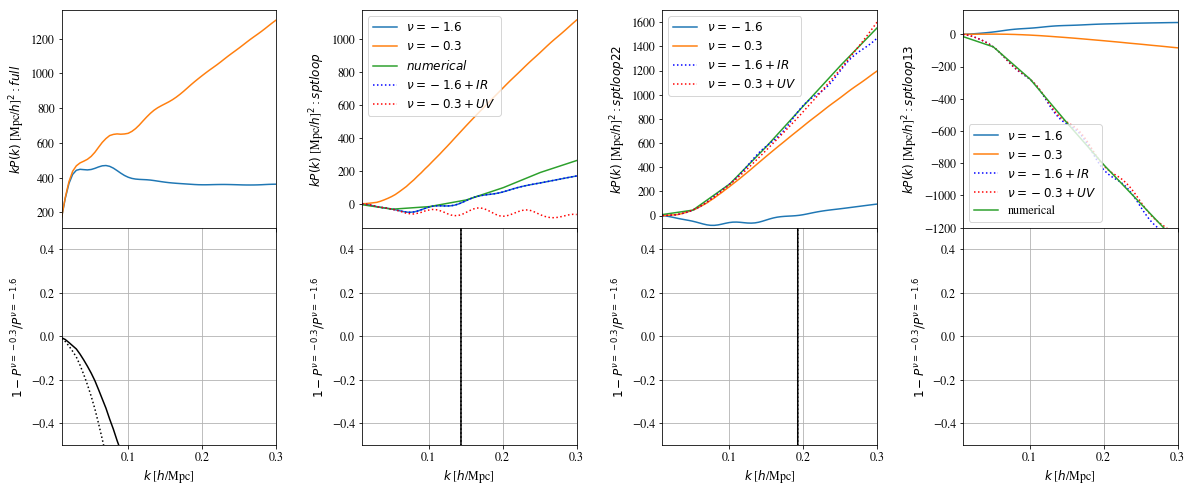

In [1120]:
f, ax = plt.subplots(2, 4, figsize=(20,8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=.4, hspace=0)

uv_finite_dm_13_quad =  uv_finite_p13_pierre(1, 1, f1)[1] * sigma_v * kdata**2 * pk11
ir_finite_dm_13_quad = -102.182 * kdata**2 * pk11 

ir_finite_dm_22_quad = 2 * 51.091 * kdata**2 * pk11 
uv_finite_dm_22_quad = 15000*kdata**2 # 20 * kdata**2 * pk11 #

for i, what in enumerate(pieces):
    ax[0,i].plot(kdata, kdata*pkm1p6[i][1], label=r'$\nu=-1.6$')
    ax[0,i].plot(kdata, kdata*pkm0p3[i][1], label=r'$\nu=-0.3$')
    ax[0,i].set_xlim(0.01, 0.3)
    ax[0,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[0,i].set_ylabel(r'$k P(k)$ [Mpc/$h$]$^{2} : %s$' % what)

    ax[1,i].plot(kdata, 1-pkm0p3[i][1]/pkm1p6[i][1], 'k')
    #ax[1,i].plot(kdata, 1-(pkm0p3[i][1] + uv_finite_dm)/pkm1p6[i][1], 'k:')
    ax[1,i].plot(kdata, 1-(pkm0p3[i][1] + uv_finite_dm - ir_finite_dm_quad)/pkm1p6[i][1], 'k:')
    ax[1,i].set_xlim(0.01, 0.3)
    ax[1,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[1,i].set_ylabel(r'$1-P^{\nu=-0.3}/P^{\nu=-1.6}$')
    ax[1,i].set_ylim(-0.5, 0.5)
    ax[1,i].grid()    

ax[0,1].plot(knum, knum*(quadnump22+quadnump13), label=r'$numerical$')
ax[0,1].plot(kdata, kdata*(pkm1p6[1][1] + ir_finite_dm_22_quad + ir_finite_dm_13_quad), 'b:', label=r'$\nu=-1.6 + IR$')
ax[0,1].plot(kdata, kdata*(pkm0p3[1][1] + uv_finite_dm_13_quad), 'r:', label=r'$\nu=-0.3 + UV$')
ax[0,1].legend()

ax[0,2].plot(knum, knum*quadnump22)
ax[0,2].plot(kdata, kdata*(pkm1p6[2][1] + ir_finite_dm_22_quad), 'b:', label=r'$\nu=-1.6 + IR$')
ax[0,2].plot(kdata, kdata*(pkm0p3[2][1] + uv_finite_dm_22_quad), 'r:', label=r'$\nu=-0.3 + UV$')
# ax[0,2].plot(kdata, kdata*(pkm0p3[i][1] + uv_finite_dm_22_quad - ir_finite_dm_22_quad), 'k:', label=r'$\nu=-0.3 + UV - IR$')
ax[0,2].set_ylim(-100, 1700)
ax[0,2].legend()

ax[0,3].plot(kdata, kdata*(pkm1p6[3][1] + ir_finite_dm_13_quad), 'b:', label=r'$\nu=-1.6 + IR$')
ax[0,3].plot(kdata, kdata*(pkm0p3[3][1] + uv_finite_dm_13_quad), 'r:', label=r'$\nu=-0.3 + UV$')
#ax[0,3].plot(kdata, kdata*(pkm0p3[3][1] + uv_finite_dm_13_quad - ir_finite_dm_13_quad), 'k:', label=r'$\nu=-0.3 + UV - IR$')
ax[0,3].plot(knum, knum*quadnump13, label='numerical')

ax[0,3].set_ylim(-1200, 150)
ax[0,3].legend()


### Biased tracers

In [28]:
reload(pybird)
bias = { "b1": 2., "b2": 0.6, "b3": 0.2, "b4": 1.2, "cct": 1.2 }
# bias = { "b1": 2., "b2": 1.2, "b3": 2., "b4": 1.2, "cct": 1.2 }
N = pybird.Correlator()
N.set({'output': 'bPk', 'multipole': 0, 'xdata': kdata, 'resum': False, 
       'keep_loop_pieces_independent': True, 'fftbias': -1.6})
N.compute({'k11': kk, 'P11': pklin})
pkm1p6 = []
for what in pieces: pkm1p6.append( N.get(bias, what=what) )

N = pybird.Correlator()
N.set({'output': 'bPk', 'multipole': 0, 'xdata': kdata, 'resum': False, 
       'keep_loop_pieces_independent': True, 'fftbias': -0.3})
N.compute({'k11': kk, 'P11': pklin})
pkm0p3 = []
for what in pieces: pkm0p3.append( N.get(bias, what=what) )

-1.6
-0.3


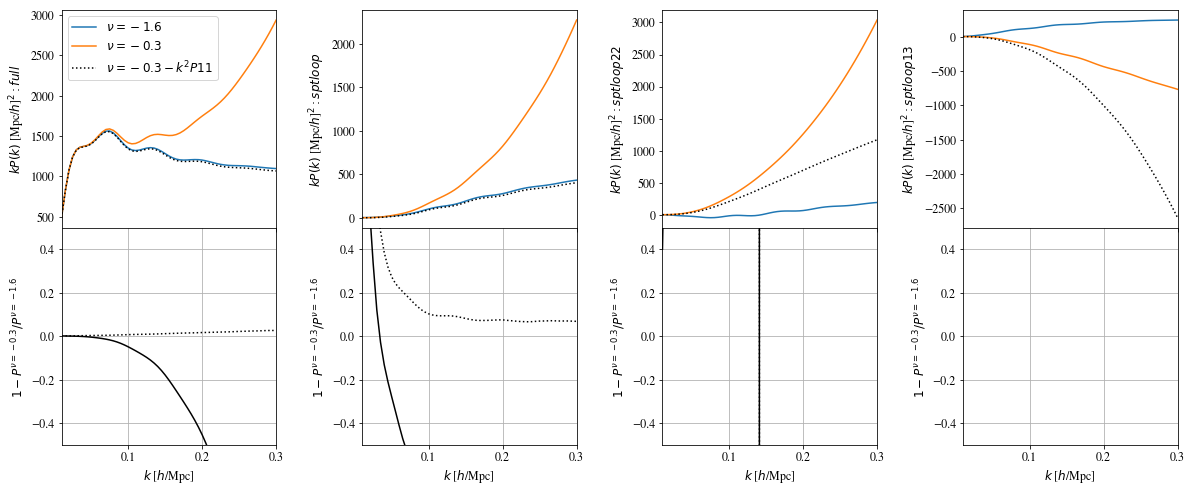

In [29]:
f, ax = plt.subplots(2, 4, figsize=(20,8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=.4, hspace=0)

uv_finite_bp13 = uv_finite_p13(bias["b1"], bias["b3"], 0)[0] - 68004.6 * kdata**2 

for i, what in enumerate(pieces):
    ax[0,i].plot(kdata, kdata*pkm1p6[i][0], label=r'$\nu=-1.6$')
    ax[0,i].plot(kdata, kdata*pkm0p3[i][0], label=r'$\nu=-0.3$')
    ax[0,i].plot(kdata, kdata*(pkm0p3[i][0] + uv_finite_bp13), 'k:', label=r'$\nu=-0.3 - k^2 P11$')
    ax[0,i].set_xlim(0.01, 0.3)
    ax[0,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[0,i].set_ylabel(r'$k P(k)$ [Mpc/$h$]$^{2} : %s$' % what)
ax[0,0].legend()

for i, what in enumerate(pieces):
    ax[1,i].plot(kdata, 1-pkm0p3[i][0]/pkm1p6[i][0], 'k')
    ax[1,i].plot(kdata, 1-(pkm0p3[i][0] + uv_finite_bp13)/pkm1p6[i][0], 'k:')
    ax[1,i].set_xlim(0.01, 0.3)
    ax[1,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[1,i].set_ylabel(r'$1-P^{\nu=-0.3}/P^{\nu=-1.6}$')
    ax[1,i].set_ylim(-0.5, 0.5)
    ax[1,i].grid()


### Biased tracers in redshift space

In [ ]:
bias = { "b1": 2., "b2": 0.6, "b3": 0.2, "b4": 1.2, "cct": 1.2, 'cr1': -1.6, 'cr2': 2. }
N = pybird.Correlator()
N.set({'output': 'bPk', 'multipole': 3, 'xdata': kdata, 'resum': False, 
       'keep_loop_pieces_independent': True, 'fftbias': -1.6})
N.compute({'k11': kk, 'P11': pklin, 'f': f1})
pkm1p6 = []
for what in pieces: pkm1p6.append( N.get(bias, what=what) )

N = pybird.Correlator()
N.set({'output': 'bPk', 'multipole': 3, 'xdata': kdata, 'resum': False, 
       'keep_loop_pieces_independent': True, 'fftbias': -0.3})
N.compute({'k11': kk, 'P11': pklin, 'f': f1})
pkm0p3 = []
for what in pieces: pkm0p3.append( N.get(bias, what=what) )

-1.6
-0.3


monopole

In [ ]:
f, ax = plt.subplots(2, 4, figsize=(20,8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=.4, hspace=0)

uv_finite_bp13 = uv_finite_p13(bias["b1"], bias["b3"], f1)[0] - 68004.6 * mu[0][0] *kdata**2 + 2608.48 * mu[2][0] * kdata**2
    
for i, what in enumerate(pieces):
    ax[0,i].plot(kdata, kdata*pkm1p6[i][0], label=r'$\nu=-1.6$')
    ax[0,i].plot(kdata, kdata*pkm0p3[i][0], label=r'$\nu=-0.3$')
    ax[0,i].plot(kdata, kdata*(pkm0p3[i][0] + uv_finite_bp13), 'k:', label=r'$\nu=-0.3 - k^2 P11$')
    ax[0,i].set_xlim(0.01, 0.3)
    ax[0,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[0,i].set_ylabel(r'$k P(k)$ [Mpc/$h$]$^{2} : %s$' % what)


    ax[1,i].plot(kdata, 1-pkm0p3[i][0]/pkm1p6[i][0], 'k')
    ax[1,i].plot(kdata, 1-(pkm0p3[i][0] + uv_finite_bp13)/pkm1p6[i][0], 'k:')
    ax[1,i].set_xlim(0.01, 0.3)
    ax[1,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[1,i].set_ylabel(r'$1-P^{\nu=-0.3}/P^{\nu=-1.6}$')
    ax[1,i].set_ylim(-0.5, 0.5)
    ax[1,i].grid()
    
ax[0,0].legend()


quadrupole

In [ ]:
f, ax = plt.subplots(2, 4, figsize=(20,8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=.4, hspace=0)

uv_finite_bpred = uv_finite_p13(bias["b1"], bias["b3"], f1)[1] + 0.4/1e-4 * kdata - 68004.6 * mu[0][2] *kdata**2 + 2608.48 * mu[2][2] * kdata**2
    
for i, what in enumerate(pieces):
    ax[0,i].plot(kdata, kdata*pkm1p6[i][1], label=r'$\nu=-1.6$')
    ax[0,i].plot(kdata, kdata*pkm0p3[i][1], label=r'$\nu=-0.3$')
    ax[0,i].plot(kdata, kdata*(pkm0p3[i][1] + uv_finite_bpred), 'k:', label=r'$\nu=-0.3 - k^2 P11$')
    ax[0,i].set_xlim(0.01, 0.3)
    ax[0,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[0,i].set_ylabel(r'$k P(k)$ [Mpc/$h$]$^{2} : %s$' % what)
    
    ax[1,i].plot(kdata, 1-pkm0p3[i][1]/pkm1p6[i][1], 'k')
    ax[1,i].plot(kdata, 1-(pkm0p3[i][1] + uv_finite_bpred)/pkm1p6[i][1], 'k:')
    ax[1,i].set_xlim(0.01, 0.3)
    ax[1,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[1,i].set_ylabel(r'$1-P^{\nu=-0.3}/P^{\nu=-1.6}$')
    ax[1,i].set_ylim(-0.5, 0.5)
    ax[1,i].grid()
    
ax[0,0].legend()

hexadecapole

In [ ]:
f, ax = plt.subplots(2, 4, figsize=(20,8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=.4, hspace=0)

uv_finite_bpred = uv_finite_p13(bias["b1"], bias["b3"], f1)[2] + 0.18/1e-4 * kdata # - 68004.6 * mu[0][4] *kdata**2 + 2608.48 * mu[2][4] * kdata**2

for i, what in enumerate(pieces):
    ax[0,i].plot(kdata, kdata*pkm1p6[i][2], label=r'$\nu=-1.6$')
    ax[0,i].plot(kdata, kdata*pkm0p3[i][2], label=r'$\nu=-0.3$')
    ax[0,i].plot(kdata, kdata*(pkm0p3[i][2] + uv_finite_bpred), 'k:', label=r'$\nu=-0.3 - k^2 P11$')
    ax[0,i].set_xlim(0.01, 0.3)
    ax[0,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[0,i].set_ylabel(r'$k P(k)$ [Mpc/$h$]$^{2} : %s$' % what)
    
    ax[1,i].plot(kdata, 1-pkm0p3[i][2]/pkm1p6[i][2], 'k')
    ax[1,i].plot(kdata, 1-(pkm0p3[i][2] + uv_finite_bpred)/pkm1p6[i][2], 'k:')
    ax[1,i].set_xlim(0.01, 0.3)
    ax[1,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[1,i].set_ylabel(r'$1-P^{\nu=-0.3}/P^{\nu=-1.6}$')
    ax[1,i].set_ylim(-0.5, 0.5)
    ax[1,i].grid()
    
ax[0,0].legend()